In [1]:
%matplotlib inline

In [2]:
# imports
from __future__ import print_function,absolute_import,division,unicode_literals
import numpy as np
import glob,os,sys,copy,imp 
from scipy import stats as scistats
import matplotlib as mpl
mpl.rcParams['font.family']='stixgeneral'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import QTable,Table
from astropy.io import ascii,fits
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from linetools.spectralline import AbsLine
import linetools.utils as ltu
from xastropy.igm.abs_sys import abssys_utils as abssys
from xastropy import spec as xpsec
from xastropy.plotting import utils as xputils
from xastropy.xutils import xdebug as xdb
from xastropy.obs import radec as xor
from xastropy.atomic import ionization as xai
from xastropy.xutils import fits as xxf
sys.path.append(os.path.abspath("../../../../py"))
from enigma.qpq import utils as qpqutils
from enigma.qpq import spec as qpqs
from enigma.qpq import stacks as qpqk
sys.path.append(os.path.abspath("../Bootstrap/py"))
import qpq9_boot as qpq9b
sys.path.append(os.path.abspath("./py"))
import qpq9_stacks as qpq9k

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


## Load stack_tup

In [3]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999),
                               vsig_cut=400*u.km/u.s,plot_indiv=False)
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1508+3635' in dd['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.

/Users/lwymarie/python/specdb/specdb/query_catalog.py:140: UserWarning: No sources found at your coordinate within tol=0.5 arcsec.  Returning None
  warnings.warn("No sources found at your coordinate within tol={:g}.  Returning None".format(tol))
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:295: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
4.50292750736 1 / Angstrom
No spectrum found for BOSSJ0008-0039 and wvobs=3921.71 Angstrom!
3.96738337038 1 / Angstrom
No spectrum found for BOSSJ0042+1350 and wvobs=3705.49 Angstrom!
81.2002163512 1 / Angstrom
43.8725850917 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ034139.19-000012.7_b1200_F.fits.gz for SDSSJ0341-0000
S/N 81.2002163512 1 / Angstrom
91.8637821431 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ080048.74+354231.3_b1200_F.fits.gz for APOJ0800+3542
S/N 91.8637821431 1 / Angstrom
6.81812554325 1 / Angstrom
Using spec-7328-56715-0428.fits.gz for BOSSJ0809+4539
S/N 6.81812554325 1 / Angstrom
No spectrum found for BOSSJ0826+4708 and wvobs=3735.68 Angstrom!
7.18837682491 1 / Angstrom
30.3853921563 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ082844.87+454518.2_b1200_F.fits.gz for SDSSJ0828+4545
S/N 30.3853921563 1 / Angstrom
30.232

/Users/lwymarie/python/specdb/specdb/query_catalog.py:145: UserWarning: Found multiple sources in the catalog. Taking the closest one
  warnings.warn("Found multiple sources in the catalog. Taking the closest one")
/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:850: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__itruediv__(other)



143.701568431 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ114436.66+095904.9_F.fits.gz for BOSSJ1144+0959
S/N 143.701568431 1 / Angstrom
No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ120416.69+022111.0_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz
Using conti=1 for HIRES
143.009676121 1 / Angstrom
47.1880601379 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz for BOSSJ1204+0221
S/N 143.009676121 1 / Angstrom
15.4009220707 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ121558.80+571555.4.fits.gz for BOSSJ1215+5715
S/N 15.4009220707 1 / Angstrom
77.9062475252 1 / Angstrom
12.5394715796 1 / Angstrom
30.426493273 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ123141.73+002913.9_b600_F.fits.gz for BOSSJ1231+0029
S/N 77.9062475252 1 / Angstrom
5.7442684952 1 / Angstrom
Using spec-6482-563

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:850: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__itruediv__(other)
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:807: UserWarning: Ignoring NAN and inf in flux
  warnings.warn("Ignoring NAN and inf in flux")


In [19]:
print(np.sum(stck_mskN,0))
sv_zfg = []
sv_Rperp = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if np.sum(stck_mskN[ii,:]) == 0:
        continue
    sv_zfg.append(dd['qpq']['Z_FG'])
    sv_Rperp.append(dd['qpq']['R_PHYS'])
np.median(sv_zfg),np.median(sv_Rperp)

[ 34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.
  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.
  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.
  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.
  34.]


(2.0324550288843883, 179.56190792887546)

## Stack and Plot

### Mean

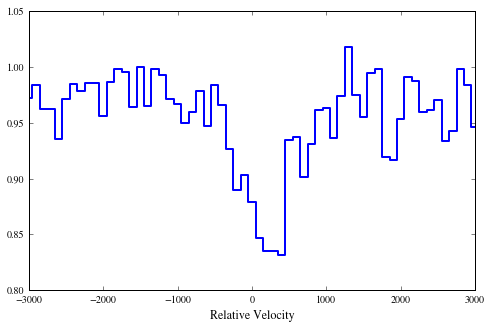

In [4]:
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Median

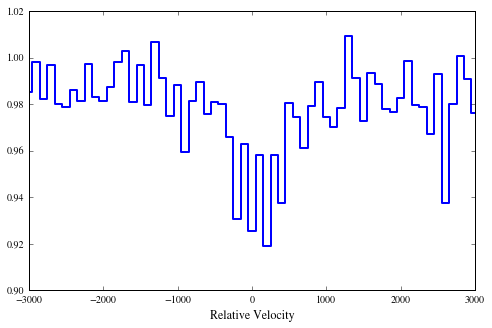

In [6]:
fin_velo, fin_flx_med, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Write 

In [7]:
from linetools.spectra.xspectrum1d import XSpectrum1D
outfil = 'Output/QPQ9_zIRMgII_1334_mean.fits'
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
fin_wave = fin_velo.to(u.AA,equivalencies=relativistic_equiv)
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx)))
xspec1d.write_to_fits(outfil,clobber=True)
outfil = 'Output/QPQ9_zIRMgII_1334_med.fits'
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx_med)))
xspec1d.write_to_fits(outfil,clobber=True)

Wrote spectrum to Output/QPQ9_zIRMgII_1334_mean.fits
Wrote spectrum to Output/QPQ9_zIRMgII_1334_med.fits


## Bootstrap

In [29]:
#Mean 
reload(qpq9b)
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/IRMgII_1334_mean.fits',stack_tup0=stack_tup)

Equivalent width skewness: Mean=0.615845, Median=0.605643, std=0.256112 for Ntrials=10000
Centroid: Mean = 202.406, scatter=80.6921
Dispersion and scatter of it:  315.585816446 113.752621725
max and min centroid:  1174.09240368 -353.164279754
Wrote ../Bootstrap/Output/IRMgII_1334_mean.fits


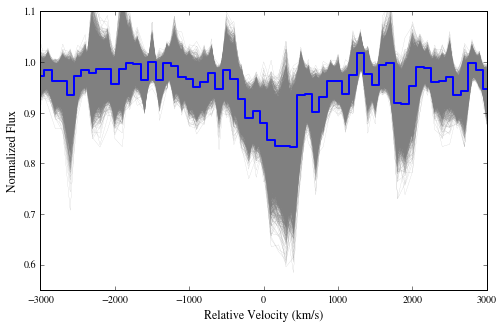

In [8]:
# plot trials
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/IRMgII_1334_mean.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.axis([-3000,3000,0.55,1.1])
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

0.0168

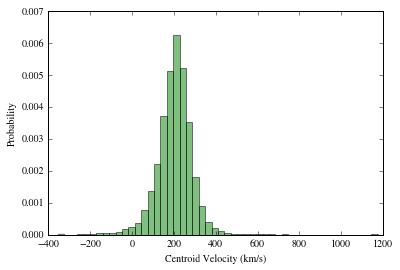

In [9]:
# Plot centroids
tau_cen = hdulist[3].data
n,bins,patches = plt.hist(tau_cen,50,normed=1,facecolor='green',alpha=0.5)
plt.xlabel('Centroid Velocity (km/s)')
plt.ylabel('Probability')
len(np.where(tau_cen < 0)[0])/len(tau_cen)

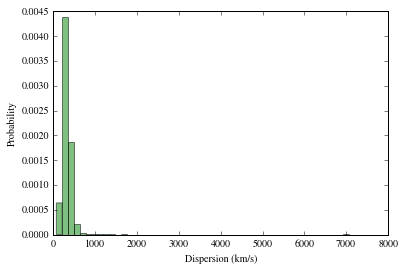

In [10]:
# Plot dispersions
tau_disp = hdulist[4].data
n,bins,patches = plt.hist(tau_disp,50,normed=1,facecolor='green',alpha=0.5)
plt.xlabel('Dispersion (km/s)')
plt.ylabel('Probability')

In [33]:
#Median
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/IRMgII_1334_med.fits',stack_tup0=stack_tup,median=True)

Equivalent width skewness: Mean=0.411399, Median=0.413311, std=0.257459 for Ntrials=10000
Centroid: Mean = 102.725, scatter=131.882
Dispersion and scatter of it:  290.132653532 190.745588627
max and min centroid:  2205.07993643 -1155.22624825
Wrote ../Bootstrap/Output/IRMgII_1334_med.fits


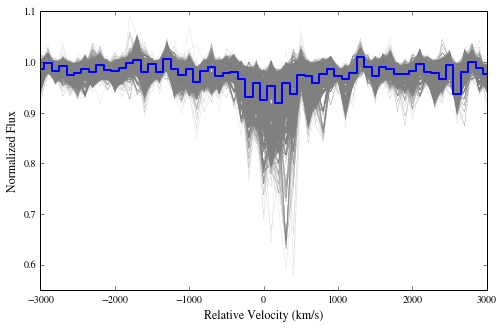

In [34]:
# plot trials
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/IRMgII_1334_med.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.axis([-3000,3000,0.55,1.1])
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

# [OIII] only

In [38]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=70*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999),
                              plot_indiv=False)
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1508+3635' in dd['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
for idx in idx_mask:
    stck_mskN[idx,:] = 0.

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
91.8637821431 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ080048.74+354231.3_b1200_F.fits.gz for APOJ0800+3542
S/N 91.8637821431 1 / Angstrom
14.3649768624 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ084159.26+392140.0.fits for BOSSJ0841+3921
S/N 14.3649768624 1 / Angstrom
98.9573309653 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ085357.49-001106.1_F.fits.gz for BOSSJ0853-0011
S/N 98.9573309653 1 / Angstrom
64.4023897193 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ093225.60+092500.2_F.fits.gz for APOJ0932+0925
S/N 64.4023897193 1 / Angstrom
47.8321699841 1 / Angstrom
14.4811127001 1 / Angstrom
56.6216841306 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ103900.01+502652.8_F.fits.gz for BOSSJ1039+5026
S/N 56.6216841306 1 / Angstrom
68.4231952803 1 / Angstrom
143.701568431 1 / Angstrom
Using 

In [39]:
np.sum(stck_mskN,0)
sv_zfg = []
sv_Rperp = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if np.sum(stck_mskN[ii,:]) == 0:
        continue
    sv_zfg.append(dd['qpq']['Z_FG'])
    sv_Rperp.append(dd['qpq']['R_PHYS'])
np.median(sv_zfg),np.median(sv_Rperp)

(2.3472455732390296, 183.37371946093424)

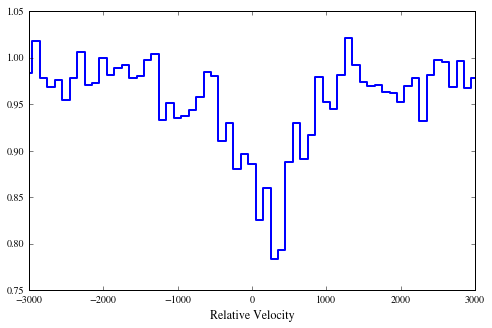

In [40]:
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

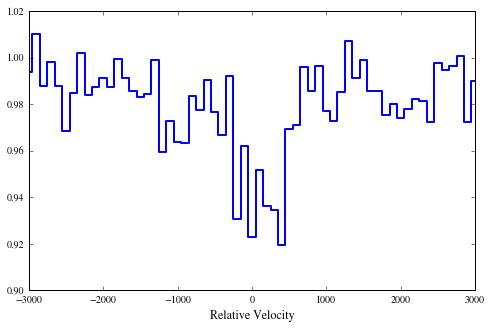

In [41]:
fin_velo, fin_flx_med, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Write

In [42]:
from linetools.spectra.xspectrum1d import XSpectrum1D
outfil = 'Output/QPQ9_zOIII_1334_mean.fits'
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
fin_wave = fin_velo.to(u.AA,equivalencies=relativistic_equiv)
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx)))
xspec1d.write_to_fits(outfil,clobber=True)
outfil = 'Output/QPQ9_zOIII_1334_med.fits'
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx_med)))
xspec1d.write_to_fits(outfil,clobber=True)

Wrote spectrum to Output/QPQ9_zOIII_1334_mean.fits
Wrote spectrum to Output/QPQ9_zOIII_1334_med.fits


## Bootstrap

In [43]:
#Mean 
reload(qpq9b)
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/OIII_1334_mean.fits',stack_tup0=stack_tup)

Equivalent width skewness: Mean=0.357849, Median=0.374364, std=0.220274 for Ntrials=10000
Centroid: Mean = 225.908, scatter=139.337
Dispersion and scatter of it:  354.855472947 283.155142514
max and min centroid:  772.059893671 -428.168649653
Wrote ../Bootstrap/Output/OIII_1334_mean.fits


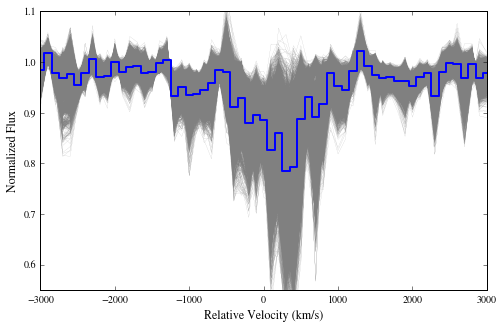

In [44]:
# plot trials
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/OIII_1334_mean.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.axis([-3000,3000,0.55,1.1])
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

0.0588

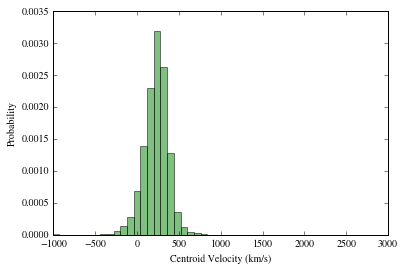

In [45]:
# Plot centroids
tau_cen = hdulist[3].data
n, bins, patches = plt.hist(tau_cen, 50, normed=1, facecolor='green', alpha=0.5,range=(-1000,3000))
plt.xlabel('Centroid Velocity (km/s)')
plt.ylabel('Probability')
len(np.where(tau_cen < 0)[0])/len(tau_cen)

In [46]:
#Median
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/OIII_1334_med.fits',stack_tup0=stack_tup,median=True)

Equivalent width skewness: Mean=0.244904, Median=0.276449, std=0.357198 for Ntrials=10000
Centroid: Mean = 122.157, scatter=190.136
Dispersion and scatter of it:  307.206094883 616.159292961
max and min centroid:  892.643375932 -1466.77292508
Wrote ../Bootstrap/Output/OIII_1334_med.fits


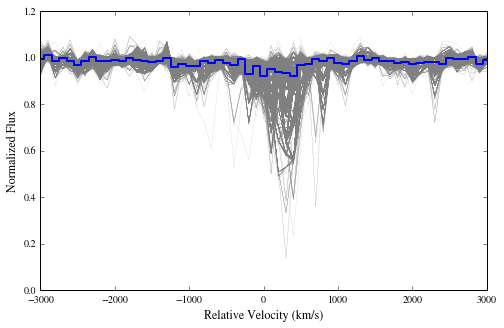

In [47]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/OIII_1334_med.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

# Plot individual spectra 

In [ ]:
qpq9k.plt_qpq9(wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,stack_fg=True,zfg_mnx=(1.6,9999))

# Split in two bins of g_UV

## MgII redshift stack

In [ ]:
# Load QPQ9 data structure
enigma_path = imp.find_module('enigma')[1]
QPQ9 = xxf.bintab_to_table(enigma_path+'/data/qpq/qpq9_final.fits')
c_QPQ9 = SkyCoord(QPQ9['FG_RA']*u.deg,QPQ9['FG_DEC']*u.deg)
# Find median g_UV
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_gUV = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_gUV.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0])
med_gUV = np.median(sv_gUV)

In [ ]:
# Mask spectra of gUV below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV <= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of gUV above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV >= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

## [OIII] redshift stack

In [ ]:
# Find median g_UV
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_gUV = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_gUV.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0])
med_gUV = np.median(sv_gUV)

In [ ]:
# Mask spectra of gUV below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV <= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of gUV above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV >= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

# Split in two bins of R_phys

## MgII redshift stack 

In [ ]:
# Find median R_phys
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_Rphys = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_Rphys.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0])
med_Rphys = np.median(sv_Rphys)

In [ ]:
# Mask spectra of R_phys below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys <= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of R_phys above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys >= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

## [OIII] redshift stack

In [ ]:
# Find median R_phys
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_Rphys = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_Rphys.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0])
med_Rphys = np.median(sv_Rphys)

In [ ]:
# Mask spectra of R_phys below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys <= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of R_phys above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys >= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

# Split in two bins of velocity separations 

## MgII redshift stack 

In [ ]:
# Find median velocity separation 
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999),atmosphere_cut=True)
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_dv = []
for idict in all_dict:
    if idict == None:
        continue
    sv_dv.append(ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value)
med_dv = np.median(sv_dv)

In [ ]:
# Mask spectra of velocity separation below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv <= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

In [ ]:
# Mask spectra of velocity separation above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv >= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

## [OIII] redshift stack

In [ ]:
# Find median velocity separation 
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_dv = []
for idict in all_dict:
    if idict == None:
        continue
    sv_dv.append(ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value)
print(sv_dv)
med_dv = np.median(sv_dv)

In [ ]:
# Mask spectra of velocity separation below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv <= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

In [ ]:
# Mask spectra of velocity separation above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv >= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))